In [2]:
%matplotlib inline

/Users/cswa648/envs/python36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Conditional clade probability summaries

## Edit primates data to five taxa
Five taxa is the smallest where we actually have to make the conditional independence assumption; we might observe a clade of greater than size 2 as the child of different parents.

In [3]:
from Bio.Nexus.Nexus import Nexus

nexus = Nexus()
nexus.read('../data/Influenza.nexus')
nexus

In [3]:
nexus.taxlabels

['CY068129_A_California_VRDL396_2009_2009/04/28',
 'CY068870_A_California_VRDL392_2009_2009/04/28',
 'CY068686_A_California_VRDL181_2009_2009/04/28',
 'CY068137_A_California_VRDL159_2009_2009/04/28',
 'CY068217_A_California_VRDL173_2009_2009/04/28',
 'CY068702_A_California_VRDL184_2009_2009/04/28',
 'CY068742_A_California_VRDL199_2009_2009/04/28',
 'CY068766_A_California_VRDL204_2009_2009/04/28',
 'CY068718_A_California_VRDL187_2009_2009/04/28',
 'CY068209_A_California_VRDL172_2009_2009/04/28',
 'CY064879_A_California_VRDL147_2009_2009/04/28',
 'CY068678_A_California_VRDL178_2009_2009/04/28',
 'CY068233_A_California_VRDL211_2009_2009/04/28',
 'CY068734_A_California_VRDL198_2009_2009/04/28',
 'CY068633_A_California_VRDL394_2009_2009/04/28',
 'CY068153_A_California_VRDL161_2009_2009/04/28',
 'CY068161_A_California_VRDL164_2009_2009/04/28',
 'CY067221_A_California_VRDL302_2009_2009/04/28',
 'CY068758_A_California_VRDL203_2009_2009/04/28',
 'CY092329_A_California_VRDL182_2009_2009/04/28',


In [4]:
# TODO: Return all with 5 taxa
nexus.write_nexus_data('../data/Influenza-short.nex', delete=nexus.taxlabels[5:])

'../data/Influenza-short.nex'

## Data structures for conditional clades

In [4]:
from splits import Split

## Processing MCMC output

In [5]:
from Bio import Phylo
trees = list(Phylo.parse('../data/Influenza-short.trees', format='nexus'))
len(trees)

10001

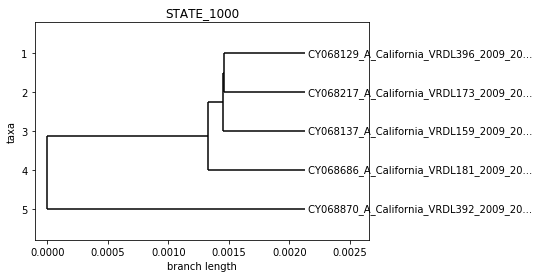

In [6]:
tree = trees[1]
Phylo.draw(tree)

In [7]:
def get_taxa(clade):
    return frozenset([leaf.name for leaf in clade.get_terminals()])
clade = list(tree.find_clades())[2]
clade.branch_length, get_taxa(clade)

(0.00012464565757352433,
 frozenset({'CY068129_A_California_VRDL396_2009_2009/04/28',
            'CY068137_A_California_VRDL159_2009_2009/04/28',
            'CY068217_A_California_VRDL173_2009_2009/04/28'}))

In [8]:
all_taxa = list(get_taxa(tree.root))
name_mapping = { name: str(i) for i, name in enumerate(all_taxa)}
name_mapping

{'CY068129_A_California_VRDL396_2009_2009/04/28': '0',
 'CY068137_A_California_VRDL159_2009_2009/04/28': '1',
 'CY068217_A_California_VRDL173_2009_2009/04/28': '2',
 'CY068870_A_California_VRDL392_2009_2009/04/28': '3',
 'CY068686_A_California_VRDL181_2009_2009/04/28': '4'}

In [9]:
for tree in trees:
    for clade in tree.find_clades():
        if clade.name is not None:
            clade.name = name_mapping[clade.name]

list(tree.find_clades())

[Clade(branch_length=0.0),
 Clade(branch_length=0.0001592378942861599),
 Clade(branch_length=1.377413413478014e-05),
 Clade(branch_length=0.00018363989578841652),
 Clade(branch_length=0.0016325343789806669, name='0'),
 Clade(branch_length=0.0016325343789806669, name='3'),
 Clade(branch_length=0.0018161742747690834, name='2'),
 Clade(branch_length=0.0018299484089038635, name='1'),
 Clade(branch_length=0.0019891863031900234, name='4')]

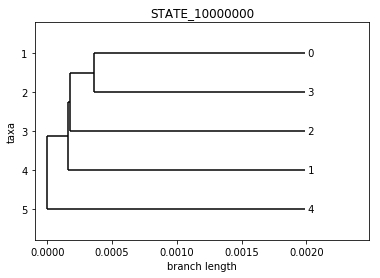

In [10]:
Phylo.draw(tree)

### Marginal posterior

In [26]:
import pickle

with open('p.pickle', 'wb') as f:
    pickle.dump(p, f)

### Conditional clade summary

In [88]:
from tqdm import tqdm_notebook as tqdm

from importlib import reload
import splits
reload(splits)
from splits import *

def normalise_dict_entries(dict_):
    sum_ = sum(dict_.values())
    return { key: value/sum_ for key, value in dict_.items() }

def convert_tree(clade):
    if(len(clade)) == 0:
        return clade.name
    else:
        return TreeNode(*[convert_tree(child) for child in clade])

tree_counts = {}

for bio_tree in tqdm(trees):
    clade = bio_tree.root
    tree = convert_tree(clade)
    if tree in tree_counts:
        tree_counts[tree] += 1
    else:
        tree_counts[tree] = 1

p = normalise_dict_entries(tree_counts)

subclade_counts = {}

for tree in tqdm(trees):
    for clade in tree.find_clades():
        taxa = get_taxa(clade)
        if len(taxa) > 2:
            if taxa not in subclade_counts:
                subclade_counts[taxa] = {}
            conditional_split = Split(taxa, get_taxa(clade[0]))
            if conditional_split not in subclade_counts[taxa]:
                subclade_counts[taxa][conditional_split] = 1
            else:
                subclade_counts[taxa][conditional_split] += 1

split_ps = { clade: normalise_dict_entries(subclades) for clade, subclades in subclade_counts.items() }
p, split_ps

({TreeNode((((0,1),4),3),2): 0.0035996400359964,
  TreeNode((((0,2),1),4),3): 0.009099090090990901,
  TreeNode(0,(((1,2),4),3)): 0.04739526047395261,
  TreeNode(0,((1,2),(3,4))): 0.029197080291970802,
  TreeNode(((0,4),(1,2)),3): 0.029197080291970802,
  TreeNode(0,((1,(2,4)),3)): 0.019998000199980003,
  TreeNode(0,(1,(2,(3,4)))): 0.005099490050994901,
  TreeNode((0,(3,4)),(1,2)): 0.013098690130986902,
  TreeNode(((0,(1,2)),4),3): 0.028597140285971403,
  TreeNode(((0,2),(1,4)),3): 0.0201979802019798,
  TreeNode(((0,3),(1,2)),4): 0.012798720127987202,
  TreeNode(0,(((1,2),3),4)): 0.0313968603139686,
  TreeNode(0,((1,3),(2,4))): 0.019098090190980903,
  TreeNode((0,((1,4),2)),3): 0.022097790220977902,
  TreeNode(0,(((1,4),3),2)): 0.0103989601039896,
  TreeNode((0,4),((1,2),3)): 0.019498050194980503,
  TreeNode((((0,2),3),1),4): 0.0035996400359964,
  TreeNode(((0,1),(2,4)),3): 0.0178982101789821,
  TreeNode(0,(1,((2,4),3))): 0.011698830116988301,
  TreeNode(0,(((1,4),2),3)): 0.0232976702329

In [89]:
p_approxs = { tree: tree_split_p(tree, split_ps) for tree in p.keys() }
p_approxs

{TreeNode((((0,1),4),3),2): 0.0030902272548770362,
 TreeNode((((0,2),1),4),3): 0.009605822185884069,
 TreeNode(0,(((1,2),4),3)): 0.04654826294558873,
 TreeNode(0,((1,2),(3,4))): 0.029197080291970802,
 TreeNode(((0,4),(1,2)),3): 0.029197080291970802,
 TreeNode(0,((1,(2,4)),3)): 0.02112914261182193,
 TreeNode(0,(1,(2,(3,4)))): 0.00519097026467566,
 TreeNode((0,(3,4)),(1,2)): 0.012883793205761008,
 TreeNode(((0,(1,2)),4),3): 0.028214410456296253,
 TreeNode(((0,2),(1,4)),3): 0.0201979802019798,
 TreeNode(((0,3),(1,2)),4): 0.012798720127987202,
 TreeNode(0,(((1,2),3),4)): 0.03122490187882865,
 TreeNode(0,((1,3),(2,4))): 0.019098090190980903,
 TreeNode((0,((1,4),2)),3): 0.0226075535682506,
 TreeNode(0,(((1,4),3),2)): 0.010327281510801457,
 TreeNode((0,4),((1,2),3)): 0.020266728766635957,
 TreeNode((((0,2),3),1),4): 0.0035890386864927963,
 TreeNode(((0,1),(2,4)),3): 0.0178982101789821,
 TreeNode(0,(1,((2,4),3))): 0.011679683095520236,
 TreeNode(0,(((1,4),2),3)): 0.02301352534949865,
 TreeNode

In [90]:
sum(p_approxs.values())

1.0000000000000002

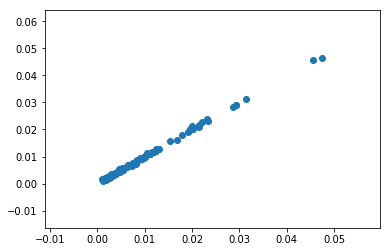

In [91]:
p_list, p_approx_list = zip(*[(p[tree], p_approxs[tree]) for tree in p.keys()])
plt.scatter(p_list, p_approx_list)

In [112]:
import autograd

tree = list(p.keys())[2]

def nonzero_splits(dict_):
    return [(split, val) for clade_splits in dict_.values() for split, val in clade_splits.items() if val > 0]

split_p_grad = autograd.grad(tree_split_p, argnum=1)
grad_dict = split_p_grad(tree, split_ps)
tree, nonzero_splits(grad_dict)

(TreeNode(0,(((1,2),4),3)),
 [(Split({'4', '0', '3', '2', '1'}, {'0'}), array(0.18015835)),
  (Split({'2', '3', '1', '4'}, {'2', '1', '4'}), array(0.13261379)),
  (Split({'2', '1', '4'}, {'2', '1'}), array(0.09069093))])

In [121]:
from autograd.numpy import log

trees = list(p.keys())

# Assume p contains all trees
def kl(p, split_ps):
    def tree_term(p, p_approx):
        return p_approx*(log(p_approx) - log(p)) if p_approx > 0 else 0
    return sum([tree_term(p[tree], tree_split_p(tree, split_ps)) for tree in p])
kl(p, split_ps)

0.0012321255861456

In [122]:
autograd.grad(kl, argnum=1)(p, split_ps)

{frozenset({'0',
            '1',
            '2',
            '3',
            '4'}): {Split({'4', '3', '0', '2', '1'}, {'4', '3', '0', '1'}): array(1.0048067), Split({'4', '0', '3', '2', '1'}, {'2', '0', '1', '4'}): array(1.00021371), Split({'4', '0', '3', '2', '1'}, {'0'}): array(1.00022839), Split({'4', '3', '0', '2', '1'}, {'4', '3', '0'}): array(1.00026458), Split({'4', '3', '0', '2', '1'}, {'2', '3', '0', '1'}): array(1.00120628), Split({'4', '0', '3', '2', '1'}, {'4', '0'}): array(1.00148878), Split({'4', '0', '3', '2', '1'}, {'2', '0', '1'}): array(1.00155873), Split({'4', '0', '3', '2', '1'}, {'4', '0', '1'}): array(1.00006004), Split({'4', '0', '3', '2', '1'}, {'2', '0'}): array(1.00015336), Split({'4', '3', '0', '2', '1'}, {'2', '3', '0', '4'}): array(1.01387184), Split({'4', '3', '0', '2', '1'}, {'2', '3', '0'}): array(1.00010816), Split({'4', '3', '0', '2', '1'}, {'3', '0'}): array(1.00036824), Split({'4', '0', '3', '2', '1'}, {'0', '1'}): array(1.00178891), Split({'4', '

In [54]:
split_p_list = [(split, p) for parent, splits in split_p.items() for split, p in splits.items()]
split_p_list = sorted(split_p_list, key = lambda x: x[1], reverse=True)

def rebuild_split_dict(split_list):
    split_dict = {}
    for split, split_p in split_list:
        parent = split.get_parent()
        if parent not in split_dict:
            split_dict[parent] = {}
        split_dict[parent][split] = split_p
    return { parent: normalise_dict_entries(split_ps) for parent, split_ps in split_dict.items() }

kl(p, rebuild_split_dict(split_p_list[:-1]))

0.02328706465825252

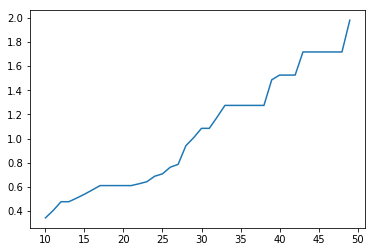

In [57]:
n_splits = list(range(10, 50))
kls = [kl(p, rebuild_split_dict(split_p_list[:-i])) for i in n_splits]
plt.plot(n_splits, kls)